In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from pandas import Series, DataFrame

In [2]:
%matplotlib inline

plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

In [3]:
cs=pd.read_csv('Demo.csv',encoding='cp949',engine='python')
tr=pd.read_csv('구매내역정보.csv',encoding='cp949',engine='python')
market=pd.read_csv('marketing_data.csv',encoding='cp949',engine='python')

In [10]:
df=pd.merge(cs,tr,on='ID')

In [11]:
df.groupby('구매지역')['구매금액'].sum().sort_values(ascending=False) #중구가 높은 이유: 주변 지가가 높으며 소비자들의
#소득수준이 높음

구매지역
서울 중구      957541000
서울 송파구     836051000
경기 안양시     781708000
부산 부산진구    449327000
부산 해운대구    438403000
             ...    
경기 김포시       3112000
경기 오산시       1944000
부산 북구        1923000
경기 양주시       1496000
경기 여주시          9000
Name: 구매금액, Length: 65, dtype: int64

In [33]:
#각 소비자별 매장 이용 횟수는?
df.groupby('ID')['구매금액'].count().sort_values(ascending=False).reset_index()
#df.구매일자=df.구매일자.astype(str).astype('datetime64')

In [456]:
#어떤 상품을 샀을 때 재방문율이 가장 높은가?
#대분류명으로 일단 나눔
ID_count=df['ID'].value_counts().reset_index()
ID_count.columns=['ID','구매횟수']
idq=ID_count.query('구매횟수>1')['ID'].reset_index()
#상품을 2번 이상 구매한 고객들
df1=pd.merge(pd.merge(idq,cs,on='ID',how='inner').drop('index',axis=1),tr,on='ID',how='inner')

{'whiskers': [<matplotlib.lines.Line2D at 0x228698e2880>,
 'caps': [<matplotlib.lines.Line2D at 0x228698e2f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x228698e2520>],
 'medians': [<matplotlib.lines.Line2D at 0x228698fe640>],
 'fliers': [<matplotlib.lines.Line2D at 0x228698fe9a0>],
 'means': []}

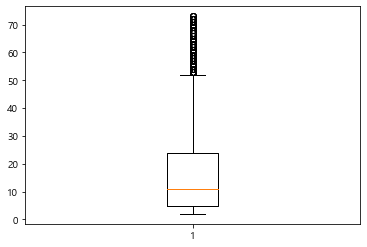

In [513]:
#두번이상 구매한 사람이 많다. 1번 방문하는 고객 거의 없음
(len(df1),
len(df))
#어떤 상품의 재방문율이 가장 높은가? 즉, 어떤 상품이 가장 많이 팔렸는가?
df1.상품대분류명.value_counts() #식품이 가장 많이 팔렸는데 식품구매와 재방문율은 상관관계가 있을까?
#구매한 횟수 vs 고객 분위별 횟수
#고객은 주로 몇번 방문했는가?
q1=df1['ID'].value_counts().quantile(0.25)
q3=df1['ID'].value_counts().quantile(0.75)
df2=df1['ID'].value_counts().reset_index()
plt.boxplot(df2.loc[(df2['ID']<q3+(q3-q1)*1.5) & (q1-(q3-q1)*1.5<df2['ID'])].drop('index',axis=1))
#대략적인 구매횟수의 분포도이다.
#plt.hist(df1['ID'].value_counts())

In [329]:
#2번이상 방문한 고객들은 처음 산 물품이 뭐였을까?
#처음 구매일자에 구매한 상품 대분류명
df1['구매일자']=df1.구매일자.astype(str).astype('datetime64')
#처음 구매한 품목들의 종류
df1.groupby('ID')['구매일자'].min() #이때 구매한 상품은?
#가장 처음 구매한 상품들을 구한 후 특정상품의 비율이 높다면 그 상품이 만족스러웠다는 것이라고 할 수 있다
b={}
for i in df1.groupby("ID")["구매일자"].min().reset_index().index:
    x=df1.loc[(df1['ID']==df1.groupby("ID")["구매일자"].min().reset_index().iloc[i]['ID'])&
            (df1['구매일자']==df1.groupby("ID")["구매일자"].min().reset_index().iloc[i]['구매일자'])]['상품대분류명'].values[0]
    b[x]=b.get(x,0)+1

In [ ]:
c={}
for i in df1.groupby("ID")["구매일자"].min().reset_index().index:
    x=df1.loc[(df1['ID']==df1.groupby("ID")["구매일자"].min().reset_index().iloc[i]['ID'])&
            (df1['구매일자']==df1.groupby("ID")["구매일자"].min().reset_index().iloc[i]['구매일자'])]['상품중분류명'].values[0]
    c[x]=c.get(x,0)+1

In [357]:
#두번 이상 방문한 사람들의 첫 방문시 구매한 상품은 의류이다. 
#첫 방문시 의류를 구매한다면 다시 방문할 확률이 높다고 해석가능한가?
first_buy1=pd.Series(b)
first_buy2=pd.Series(c)

In [360]:
#처음 구매하는 상품의 구매횟수와 총 구매횟수를 묶음
buy_list=pd.merge(first_buy1.sort_values(ascending=False).reset_index(),df1['상품대분류명'].value_counts().reset_index(),on='index'
                  ,how='outer')
buy_list1=pd.merge(first_buy2.sort_values(ascending=False).reset_index(),df1['상품중분류명'].value_counts().reset_index(),on='index'
        ,how='outer')
buy_list.columns=['대분류품목','첫방문시 구매 횟수','총구매횟수']
buy_list1.columns=['중분류품목','첫방문시 구매 횟수','총구매횟수']

,대분류품목,첫방문시 구매 횟수,총구매횟수
0,의류잡화,1039,32015
1,식품,903,38589
2,가전제품,767,10980
3,생활잡화,389,10085
4,레포츠,313,8015
5,명품,49,1226
6,가구,33,733


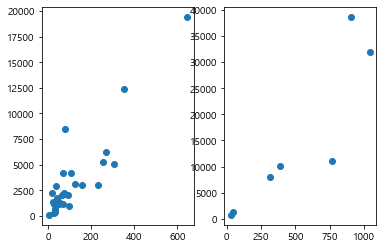

In [376]:
buy_list.sort_values(by='총구매횟수',ascending=False)
plt.subplot(1,2,1)
plt.scatter(buy_list1.sort_values(by='총구매횟수',ascending=False)['첫방문시 구매 횟수'],
           buy_list1.sort_values(by='총구매횟수',ascending=False)['총구매횟수'])
plt.subplot(1,2,2)
plt.scatter(buy_list.sort_values(by='총구매횟수',ascending=False)['첫방문시 구매 횟수'],
           buy_list.sort_values(by='총구매횟수',ascending=False)['총구매횟수'])
#첫방문시 구매한 상품들이 총 구매횟수도 높게 나타난다.

처음 구매한 상품= 의류가 가장 많았다. 의류에 대한 상품의 만족도가 가장 높다고 할 수 있는건가?
어느 매장의 고객 재방문 횟수가 가장 많은가?

In [387]:
one_time=pd.merge(pd.merge(ID_count.query("구매횟수==1"),cs,on ='ID'),tr,on='ID')
one_time['구매지역'].value_counts().head(1)
#한번 이용한 고객은 부산 사상구 점포를 가장 많이 방문

부산 사상구    12
Name: 구매지역, dtype: int64

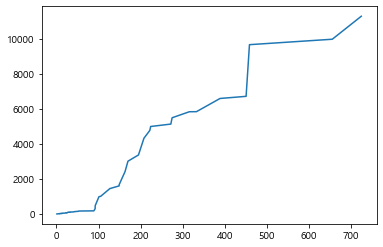

In [402]:
df1.groupby('구매지역')['ID'].nunique().sort_values(ascending=False)
#서울 중구에서 재방문을 한 고객의 수가 가장 많았다.
df1.groupby('구매지역')['ID'].count().sort_values(ascending=False)
#가장 구매가 많이 이루어진 곳은 서울 송파구
#재방문 고객의 수와 구매의 많이 이루어진 수의 관계는?
plt.plot(df1.groupby('구매지역')['ID'].nunique().sort_values(ascending=False),
        df1.groupby('구매지역')['ID'].count().sort_values(ascending=False))
#재방문한고객의 수가 많을수록 총 판매수가 많다.

In [441]:
buy_list #주얼리를 구매한 고객은 첫방문시 주얼리를 구매하지 않았다. 
#주얼리를 구매한 사람들의 구매 양상은?

,대분류품목,첫방문시 구매 횟수,총구매횟수
0,의류잡화,1039,32015
1,식품,903,38589
2,가전제품,767,10980
3,생활잡화,389,10085
4,레포츠,313,8015
5,명품,49,1226
6,가구,33,733


In [439]:
one_time #한번만 방문한 사람들도 주얼리를 구매한 고객이 없음
#주얼리를 구매한 사람들은 어떤 상품들을 추가로 구매하였는가?
jew=df1.query('상품중분류명=="주얼리"')["ID"].unique()
df1.query('ID in @jew').groupby('ID')['상품중분류명'].count().mean()
#대체적으로 점포방문 횟수가 많은 사람들이 주얼리를 구매한다.

100.94117647058823

상품의 품질요인과 서비스 요인도 소비자 만족도에 영향을 미치는 것으로 나타났지만 소비자 만족도에 가장 많은 영향을 미치는 요인은 접근용이성 요인으로 나
타났다 또한 만족도가 높을수록 재방문율도 높다

In [471]:
 #구매횟수를 범위로 나눠 구매횟수 분위별 구매액의 차이는 어떻게 되는지 구하기.
#df3=pd.merge(df1,ID_count,on='ID')


In [472]:
df3['구매횟수분위'] = pd.qcut(df3['구매횟수'], q=5, labels=range(5,0,-1)).astype(int)

In [473]:
df3.groupby('구매횟수분위')['구매금액'].mean()# 2번이상 구매한 고객중 구매횟수가 많은 고객일수록 평균 구매금액은 적다.

구매횟수분위
1     50257.304100
2     62551.525506
3     66140.019112
4     84200.387655
5    118525.483886
Name: 구매금액, dtype: float64

In [474]:
df3.groupby('구매횟수분위')['구매금액'].count()

구매횟수분위
1    20023
2    20485
3    19883
4    20121
5    21131
Name: 구매금액, dtype: int64

In [477]:
df4=df3.loc[(df3['구매횟수']<q3+(q3-q1)*1.5)&(q1-(q3-q1)*1.5<df3['구매횟수'])]
#이상값들을 제거한 후 다시 분위내고 구해보기
df4['구매횟수분위'] = pd.qcut(df4['구매횟수'], q=5, labels=range(5,0,-1)).astype(int)

<ipython-input-477-c0ddd84f5164>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['구매횟수분위'] = pd.qcut(df4['구매횟수'], q=5, labels=range(5,0,-1)).astype(int)


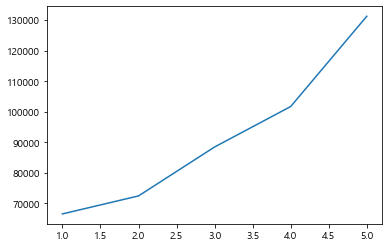

In [483]:
df4.groupby('구매횟수분위')['구매금액'].mean()
#이상치를 제거해도 구매횟수가 낮은 고객일수록 구매액이 많다.
plt.plot(df4.groupby('구매횟수분위')['구매금액'].mean())

재방문율을 높이기위해 접근 용이성과 상품의 품질을 높일 필요가 있다. 재방문한 고객이 가장 많이 구매한 첫 구매상품은
의류로 나옴. 의류에 대한 만족도가 높다는 뜻. 낮을수록 상품에대한 만족도가 낮다고 할 수 있다.

또한 매장의 재방문한 고객의 수와 총 판매량에 대한 양의 상관관계가 있다고 할 수 있다.
재방문율을 높이기 위해 해야할 것은?
재방문 횟수가 많을수록 평균적으로 구매하는 금액은 낮아진다. 재방문율이 높은 고객은 접근용이성이 있는가?

In [497]:
#구매횟수가 많은 고객들의 거주지,구매지의 차이의 관계는?
diff_region={}
for i in range(1,6):
    x=df4.loc[df4['구매횟수분위']==i].groupby('거주지역')['구매지역'].nunique().sum()
    diff_region[i]=x
    
#구매횟수가 많은 고객일수록 거주지역과 구매지역의 차이가 적다.?

{1: 265, 2: 308, 3: 345, 4: 487, 5: 714}

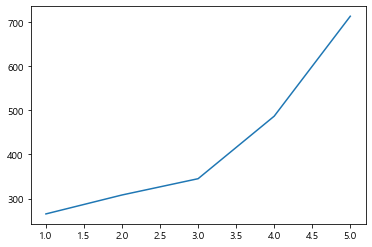

In [501]:
plt.plot(pd.Series(diff_region))
diff_region

재방문율을 높이기위해 해야하는 것은 상품의 만족도를 높이는 것. 매장의 입점시 고려사항은 접근 용이성.
첫방문시 구매하는 의류,식품등의 만족도를 높여 총 판매액을 높일 수 있다.
만족도에 휴게시설도 영향을 줄 수 있다. 따라서 상품의 만족도를 높이고 휴게시설의 배치를 조정해야함.

In [522]:
df1.sort_values(by=['ID', '구매일자']).drop_duplicates(['ID']).query('취소여부==0')
#첫구매시의 피벗테이블


,ID,성별,연령,거주지역,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부
97723,741463,1,78,서울 동대문구,의류잡화,남성용의류-캐주얼,서울 동대문구,20140115,13,1,44000,0
76050,909249,2,56,부산 해운대구,의류잡화,남성용의류-정장류,부산 중구,20140118,13,1,999000,0
92474,1065068,2,64,서울 성동구,생활잡화,화장품,서울 송파구,20140706,19,1,102000,0
101528,1310410,2,69,서울 마포구,의류잡화,여성용의류-SPA,경기 고양시,20140119,17,2,53000,0
97881,1387032,2,56,서울 은평구,의류잡화,구두,서울 중구,20140118,15,1,27000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100345,998386599,2,67,서울 송파구,가전제품,생활가전,서울 송파구,20141112,18,1,49000,0
85047,998623524,2,58,경기 안양시,식품,건강식품,경기 안양시,20140221,11,1,18000,0
100703,999024423,2,58,서울 송파구,가전제품,주방가전,서울 송파구,20140517,16,1,6000,0
78589,999184958,2,61,부산 해운대구,생활잡화,침구류,부산 해운대구,20140115,14,1,44000,0
